# Hands-on Lithium Ion Battery (LIB) modelling

Installing libraries

In [1]:
%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install pandas
%pip install pybamm==22.3

In [2]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Model set up

In [3]:
# set the model type
model = pybamm.lithium_ion.DFN() # pybamm.lithium_ion.NewmanTobias()

# # set the default model geometry
# geometry = model.default_geometry

Uncomment the following plot to show all the model paramenters

In [4]:
format_str = '{:<75}  {:>20}'
print(format_str.format('PARAMETER', 'VALUE'))
print("-"*97)
for key, value in model.default_parameter_values.items():
    try:
        print(format_str.format(key, value))
    except TypeError:
        print(format_str.format(key, value.__str__()))

PARAMETER                                                                                   VALUE
-------------------------------------------------------------------------------------------------
Negative current collector thickness [m]                                                  2.5e-05
Negative electrode thickness [m]                                                           0.0001
Separator thickness [m]                                                                   2.5e-05
Positive electrode thickness [m]                                                           0.0001
Positive current collector thickness [m]                                                  2.5e-05
Electrode height [m]                                                                        0.137
Electrode width [m]                                                                         0.207
Negative tab width [m]                                                                       0.04
Negative tab centre 

In [5]:
# set the default model parameters
# param = model.default_parameter_values
PARAMETERS = "Chen2020" # Marquis2019 Chen2020
chemistry = pybamm.parameter_sets.Chen2020
chemistry["electrolyte"] = "lipf6_EC_EMC_3_7_Landesfeind2019" # 'lipf6_Nyman2008'
# chemistry['negative electrode'] = "graphite_ORegan2021" #  'graphite_Chen2020'
param = pybamm.ParameterValues(chemistry) #  Ecker2015  Chen2020
# NOMINAL_Q = 2.0 # [Ah]
# param['Nominal cell capacity [A.h]'] = NOMINAL_Q  
# param['Cell volume [m3]'] = 7.8e-06*2
param["Current function [A]"] = "[input]" # [A] will be a model input
param["Ambient temperature [K]"] = "[input]"
# param["Negative electrode thickness [m]"] = 8.52e-05*1.15 # 8.52e-05
# param['Positive electrode thickness [m]'] = 7.56e-05*1.15 # 
# param['Nominal cell capacity [A.h]'] = 5.0*1.15 # 5.0
# param['Typical current [A]'] = 5.0*1.15 # 5.0
# param["Cell volume [m3]"] =  2.42e-05 *1.1 # 2.42e-05


# set the parameters for the model and the geometry
param.process_model(model)
geometry = pybamm.battery_geometry()
param.process_geometry(geometry)

Let's chage the nominal capacity

In [6]:
# # mesh the domains
# mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# # discretise the model equations
# disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
# disc.process_model(model)
submesh_types = {
    "negative electrode": pybamm.Uniform1DSubMesh,
    "separator": pybamm.Uniform1DSubMesh,
    "positive electrode": pybamm.Uniform1DSubMesh,
    "negative particle": pybamm.Uniform1DSubMesh,
    "positive particle": pybamm.Uniform1DSubMesh,
    'negative particle size': pybamm.Uniform1DSubMesh,
    'positive particle size': pybamm.Uniform1DSubMesh,
    "current collector": pybamm.SubMesh0D
}

var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 40, var.x_s: 15, var.x_p: 40, var.r_n: 50, var.r_p: 50}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
spatial_methods = {
    'current collector': pybamm.ZeroDimensionalSpatialMethod(),
    "macroscale": pybamm.FiniteVolume(),
    "negative particle": pybamm.FiniteVolume(),
    "positive particle": pybamm.FiniteVolume(),
}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)

In [7]:
macroscale = ["negative electrode", "separator", "positive electrode"]
x_var = pybamm.SpatialVariable("x", domain=macroscale)
r_var = pybamm.SpatialVariable("r", domain=["negative particle"])
# Discretise
x_disc = disc.process_symbol(x_var)
r_disc = disc.process_symbol(r_var)

# Evaluate
x = x_disc.evaluate()
r = r_disc.evaluate()
t_ne = param["Negative electrode thickness [m]"] 
t_sp = param["Separator thickness [m]"] 
t_pe = param["Positive electrode thickness [m]"]
t_cell = t_ne + t_sp + t_pe
r_ne = param["Negative particle radius [m]"]

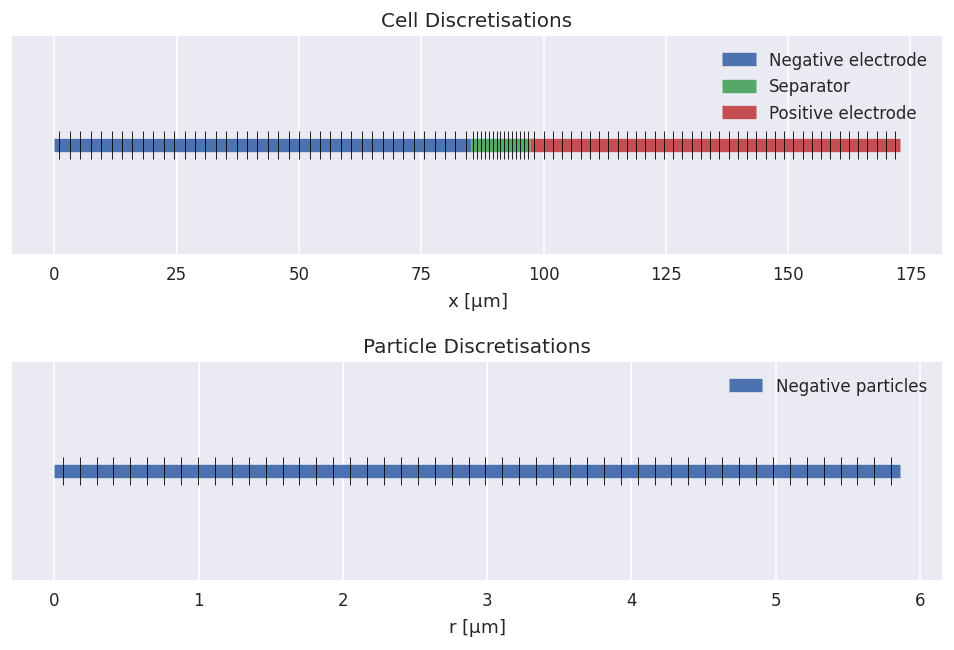

In [8]:
fig = plt.figure(figsize=(10,6), dpi=120)
m2um = 1e6

with plt.style.context('seaborn'):
    ax_x = fig.add_subplot(211)
    ax_r = fig.add_subplot(212)
    plt.subplots_adjust(hspace = .5)
    start = 0.
    for t, label in zip([t_ne, t_sp, t_pe], ['Negative electrode', 'Separator', 'Positive electrode']):
        ax_x.plot(np.r_[start, start+t]*m2um, [0, 0], label=label, lw=8, solid_capstyle='butt')
        start += t
    ax_x.scatter(x*t_cell*m2um, np.zeros(len(x)), marker='|', color='k', lw=.5, s=300, zorder=10)
    ax_r.plot(np.r_[0, r_ne]*m2um, [0, 0], label="Negative particles", lw=8, solid_capstyle='butt')
    ax_r.scatter(r*r_ne*m2um, np.zeros(len(r)), marker='|', color='k', lw=.5, s=300, zorder=10)
    ax_x.set_xlabel(r"x [$\mathrm{\mu m}$]")
    ax_x.set_ylabel(r"y [$\mathrm{\mu m}$]")
    ax_x.get_yaxis().set_visible(False)
    ax_x.legend()
    ax_x.set_title("Cell Discretisations")
    ax_r.set_xlabel(r"r [$\mathrm{\mu m}$]")
    ax_r.get_yaxis().set_visible(False)
    ax_r.legend()
    ax_r.set_title("Particle Discretisations")

plt.show()

In [9]:
NOMINAL_Q = param['Nominal cell capacity [A.h]'] 
C_RATE = NOMINAL_Q / 1. # [A]
T = 300 # K

Now lets discharge the battery per 1h



In [10]:
# Lets use the default solver to compute the discharge curve
solver = pybamm.CasadiSolver()
n = 3601 # how many point to evaluate
t_eval = np.linspace(0, 3600, n) # [s]
solution = solver.solve(model, t_eval, inputs={'Current function [A]': C_RATE, "Ambient temperature [K]": T})

lets plot the result

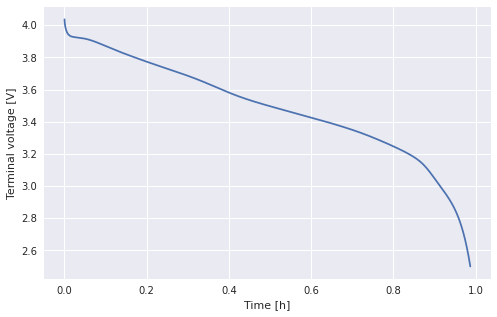

In [11]:
time = solution["Time [h]"].entries
voltage = solution["Terminal voltage [V]"].entries
fig = plt.figure(figsize=(8,5))

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    ax.plot(time, voltage)
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")

plt.show()

## Effect of C-rate 
Computing Voltage profile at different C Rate

In [12]:
C_RATES = [2, 1, 0.5]

crate_result = pd.DataFrame(columns=["C-rare", "Time [h]", "Voltage [V]"])

for i, c_rate in enumerate(C_RATES) :
    t_eval = np.linspace(0, 3600/c_rate,  int(20000*c_rate))
    solution = solver.solve(model, t_eval, inputs={'Current function [A]': C_RATE*c_rate, "Ambient temperature [K]": T})
    crate_result.loc[i, "C-rare"] = c_rate
    crate_result.loc[i, "Time [h]"] = solution["Time [h]"].entries
    crate_result.loc[i, "Voltage [V]"] = solution["Terminal voltage [V]"].entries
    # times.append(
    #     solution["Time [h]"].entries
    # )
    # voltages.append(
    #     solution["Terminal voltage [V]"].entries
    # )
    print("C-Rate {:>6}: Discharged in {:>6.3g} h".format(c_rate, crate_result.loc[i, "Time [h]"].max()))

C-Rate      2: Discharged in  0.474 h
C-Rate      1: Discharged in  0.987 h
C-Rate    0.5: Discharged in      2 h


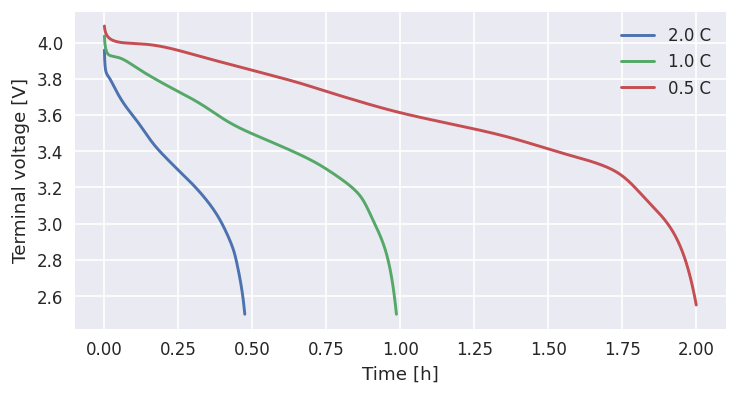

In [13]:
fig = plt.figure(figsize=(7,3.5), dpi=120)

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    for i, c_rate in enumerate(C_RATES):
        ax.plot(crate_result.loc[i, "Time [h]"], crate_result.loc[i, "Voltage [V]"], label=f'{c_rate:1.1f} C')
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")
    ax.legend()

plt.show()

## Effect of T

In [14]:
T_test = [-30, 0, 30, 60] # [C°]

temeperature_result = pd.DataFrame(columns=["T [C°]", "Time [h]", "Voltage [V]"])

for i, temp in enumerate(T_test) :
    t_eval = np.linspace(0, 3600, 10000)
    solution = solver.solve(model, t_eval, inputs={'Current function [A]': C_RATE, "Ambient temperature [K]": 273.15+temp})
    temeperature_result.loc[i, "T [C°]"] = temp
    temeperature_result.loc[i, "Time [h]"] = solution["Time [h]"].entries
    temeperature_result.loc[i, "Voltage [V]"] = solution["Terminal voltage [V]"].entries
    # times.append(
    #     solution["Time [h]"].entries
    # )
    # voltages.append(
    #     solution["Terminal voltage [V]"].entries
    # )
    print("T {:>6}: Discharged in {:>6.3g} h".format(temp, temeperature_result.loc[i, "Time [h]"].max()))

T    -30: Discharged in 0.0349 h
T      0: Discharged in  0.953 h
T     30: Discharged in  0.988 h
T     60: Discharged in  0.993 h


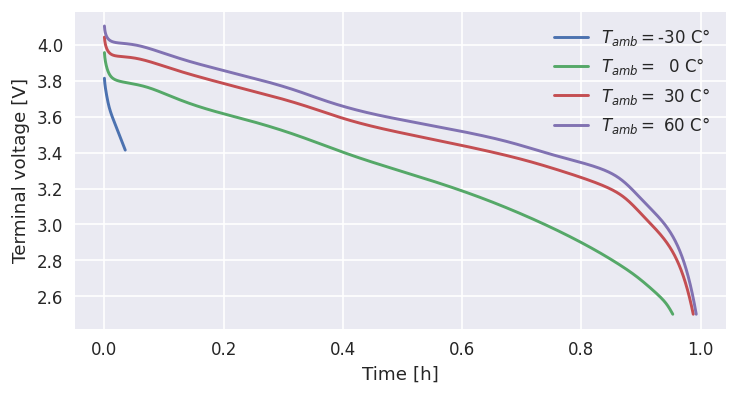

In [15]:
fig = plt.figure(figsize=(7,3.5), dpi=120)

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    for i, temp in enumerate(T_test):
        ax.plot(temeperature_result.loc[i, "Time [h]"], temeperature_result.loc[i, "Voltage [V]"], label=f'$T_{{amb}}=${temp:>3.0f} C°')
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")
    ax.legend()

plt.show()

## Discharge-Chaege curve

In [16]:
model_exp = pybamm.lithium_ion.DFN()
cut_off_l = param['Lower voltage cut-off [V]']
cut_off_u = param['Upper voltage cut-off [V]']
experiment = pybamm.Experiment(
    [
        (f"Discharge at C/2 for 2 hours or until {cut_off_l} V",
        f"Charge at C/2 for 2.1 hours or until {cut_off_u} V",
        f"Discharge at C/2 for 2 hours or until {cut_off_l} V",
        f"Charge at C/2 for 2.1 hours or until {cut_off_u} V"),
    ]
)
sim = pybamm.Simulation(model_exp, experiment=experiment, parameter_values=pybamm.ParameterValues(chemistry))
solution = sim.solve()

In [17]:
from scipy.integrate import trapz

def get_energy(V, I, t):
    return trapz(V*I, x=t)

In [18]:
time = solution["Time [h]"].entries
voltage = solution["Terminal voltage [V]"].entries
i_change_0 = np.where(voltage == voltage[(time > 3.5) & (time <= 6.8)].max())[0][0]
i_change_1 = np.where(voltage == voltage[(time > 3.5) & (time <= 6.8)].min())[0][-1]
t_change_0 = time[i_change_0]
t_change_1 = time[i_change_1]
time_discharge = time[(time > t_change_0) & (time <= t_change_1)]
voltage_discharge = voltage[(time > t_change_0) & (time <= t_change_1)]
time_charge = time[time >= t_change_1]
voltage_charge = voltage[time >= t_change_1]

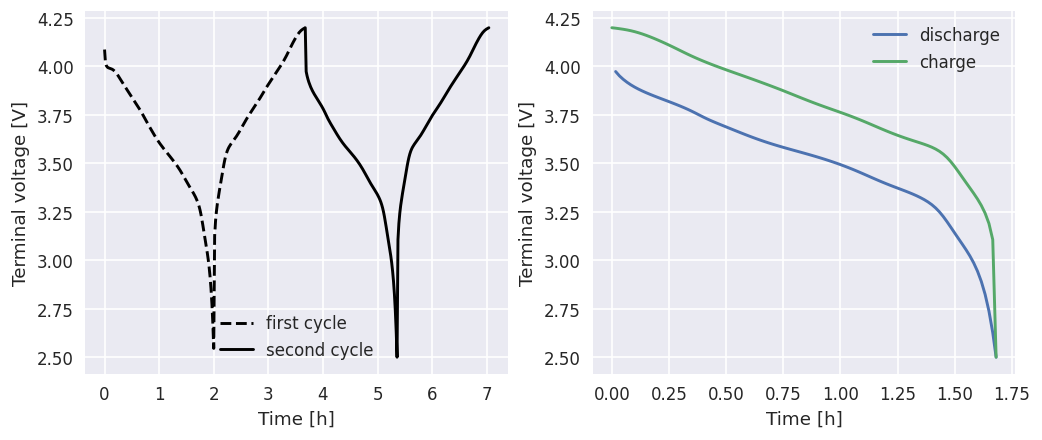

In [19]:
fig = plt.figure(figsize=(10,4), dpi=120)

with plt.style.context('seaborn'):
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(time[time <= t_change_0], voltage[time <= t_change_0], '--k', label='first cycle')
    ax1.plot(time[time >= t_change_0], voltage[time >= t_change_0], '-k', label='second cycle')
    ax2.plot(time_discharge-t_change_0, voltage_discharge, label='discharge')
    ax2.plot(time_charge[::-1]-t_change_1, voltage_charge, label='charge')
    for ax in [ax1, ax2]:
        ax.set_xlabel("Time [h]")
        ax.set_ylabel("Terminal voltage [V]")
        ax.legend()
plt.show()

In [20]:
energy_discharge = get_energy(voltage_discharge, C_RATE/2, time_discharge)
energy_charge = get_energy(voltage_charge, C_RATE/2, time_charge)

In [21]:
eta = energy_discharge/energy_charge
print(f"Battery efficiency: {eta*100:1.2f} %")

Battery efficiency: 91.29 %


## Compute the Ragone plot


In [ ]:
C_RATES = [3, 2.5, 2, 1.5, 1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01]

crate_result2 = pd.DataFrame(columns=["C-rare", "Time [h]", "Voltage [V]"])

for i, c_rate in enumerate(C_RATES) :
    t_eval = np.linspace(0, 4000/c_rate, max(500, int(30000*c_rate)) )
    solution = solver.solve(model, t_eval, inputs={'Current function [A]': C_RATE*c_rate, "Ambient temperature [K]": T})
    crate_result2.loc[i, "C-rare"] = c_rate
    crate_result2.loc[i, "Time [h]"] = solution["Time [h]"].entries
    crate_result2.loc[i, "Voltage [V]"] = solution["Terminal voltage [V]"].entries
    # times.append(
    #     solution["Time [h]"].entries
    # )
    # voltages.append(
    #     solution["Terminal voltage [V]"].entries
    # )
    print("C-Rate {:>6}: Discharged in {:>6.3g} h".format(c_rate, crate_result2.loc[i, "Time [h]"].max()))

In [ ]:
def get_cell_volume_and_mass(param):
    vol = param['Cell volume [m3]']
    t = 0
    rho = 0
    componets = [
        'Negative electrode',
        'Negative current collector',
        'Positive electrode',
        'Positive current collector',
        'Separator'
    ]
    for comp in componets:
        rho_ = param[comp+' density [kg.m-3]']
        t_ = param[comp+' thickness [m]']
        rho += rho_*t_
        t += t_
    rho /= t
    mass = rho*vol
    return vol, mass

CELL_VOL, CELL_MASS = get_cell_volume_and_mass(param)

ragone_result = pd.DataFrame(columns=["C-rare", "Specific Power [W/kg]", "Specific Energy [Wh/kg]"])

for i, (c_rate, t,v) in enumerate(zip(C_RATES, crate_result2["Time [h]"], crate_result2["Voltage [V]"])):
    energy = get_energy(v, c_rate*C_RATE, t*3600) # [J]
    power = energy / (t.max()*3600) # [W]
    energy = energy/3600 # [Wh]
    ragone_result.loc[i, "C-rare"]  = c_rate
    ragone_result.loc[i, "Specific Energy [Wh/kg]"] = energy/CELL_MASS
    ragone_result.loc[i, "Specific Power [W/kg]"] = power/CELL_MASS

In [ ]:
ragone_result

In [ ]:
fig = plt.figure(figsize=(7,3.5), dpi=120)

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    for i, temp in enumerate(T_test):
        ax.loglog(ragone_result[ "Specific Power [W/kg]"], ragone_result[ "Specific Energy [Wh/kg]"])
    ax.set_xlabel("Specific Power [W/kg]")
    ax.set_ylabel("Specific Energy [Wh/kg]")
    ax.grid(True)
plt.show()

## Find the 1 C-rate current

We are going to use a old but simple method but effective metod to find the exact value of current to discharge the battery afte 1 hour with a cut of current of 3.3 V.
We are going to use [Secant Method](https://en.wikipedia.org/wiki/Secant_method) to find the zero of the follinwing target function:

$ f(i) = V_{end}(i) - V_{cut-off} $ 

> Note: a battery is discharge when the terminal voltage cross the cut-off value

In [ ]:
# from scipy.optimize import differential_evolution # genetic algorithm optimizer

# CUTOFF_V = 3.3 
# i_min = NOMINAL_Q * 0.6/ 1.
# i_max = NOMINAL_Q * 1.5 / 1.

# def f_target(i):
#     solution = solver.solve(model, t_eval, inputs={'Current function [A]': i})
#     V_new = solution["Terminal voltage [V]"].entries[-1]
#     return V_new-CUTOFF_V

# differential_evolution(f_target, bounds=[(i_min, i_max)])

In [ ]:
# from scipy.interpolate import interp1d

# CUTOFF_V = 3.0

# i_0 = NOMINAL_Q * 0.8/ 1.
# i_1 = NOMINAL_Q * 1.1 / 1.

# def f_target(t):
#     return t-1

# def get_cut_off_time(V, t):
#     # diff = np.abs(V-CUTOFF_V)
#     # indx = np.where(diff == diff.min())[0]
#     # return t[indx][0]
#     f_int = interp1d(V, t)
#     return f_int(CUTOFF_V)

# t_eval = np.linspace(0, 7200, 7201)
# solution_0 = solver.solve(model, t_eval, inputs={'Current function [A]': i_0})
# tc_0 = get_cut_off_time(solution_0["Terminal voltage [V]"].entries, 
#                         solution_0["Time [h]"].entries ) 
# solution_1 = solver.solve(model, t_eval, inputs={'Current function [A]': i_1})
# tc_1= get_cut_off_time(solution_1["Terminal voltage [V]"].entries, 
#                         solution_1["Time [h]"].entries ) 

# # The loop end when diffence between two consecutive aptempt are less that 5% 
# n_int = 0
# while abs(tc_0-tc_1) > 0.001:
#     i_new = i_1 - f_target(tc_1)*(i_1-i_0) / (f_target(tc_1)- f_target(tc_0))
#     solution = solver.solve(model, t_eval, inputs={'Current function [A]': i_new})
#     tc_new= get_cut_off_time(solution["Terminal voltage [V]"].entries, 
#                              solution["Time [h]"].entries )
#     print(f"[{n_int+1}]\ti_new: {i_new:1.5g} A\ttc_new: {tc_new:1.5g} h") 
#     i_0 = i_1
#     i_1 = i_new
#     tc_0 = tc_1
#     tc_1 = tc_new
#     n_int += 1
# C_RATE = i_1
# print(f"C-rate current = {C_RATE} A")

Let's plot the result

In [ ]:
# t_eval = np.linspace(0, 3600, 361)
# solution_old = solver.solve(model, t_eval, inputs={'Current function [A]': NOMINAL_Q/1.})
# solution = solver.solve(model, t_eval, inputs={'Current function [A]': C_RATE})

# time_old = solution_old["Time [h]"].entries
# voltage_old = solution_old["Terminal voltage [V]"].entries
# time = solution["Time [h]"].entries
# voltage = solution["Terminal voltage [V]"].entries

# fig = plt.figure(figsize=(6,4), dpi=120)

# with plt.style.context('seaborn'):
#     ax = fig.add_subplot(111)
#     ax.plot(time_old, voltage_old, label='Nominal')
#     ax.plot(time, voltage, label='1 C-rate')
#     ax.set_xlabel("Time [h]")
#     ax.set_ylabel("Terminal voltage [V]")
#     ax.legend()

# plt.show()

In [ ]:
# np.linspace(0, 7200, 181)

In [ ]:
# solution_1["Time [h]"].entries

In [ ]:
# time = solution_0["Time [h]"].entries
# voltage = solution_0["Terminal voltage [V]"].entries
# time_1 = solution_1["Time [h]"].entries
# voltage_1 = solution_1["Terminal voltage [V]"].entries

# fig = plt.figure(figsize=(8,5))

# with plt.style.context('seaborn'):
#     ax = fig.add_subplot(111)
#     ax.plot(time, voltage)
#     ax.plot(time_1, voltage_1)
#     ax.set_xlabel("Time [h]")
#     ax.set_ylabel("Terminal voltage [V]")

# plt.show()

In [ ]:
# # Solution with current = 0.68
# old_solution = solver.solve(model, t_eval, inputs={"Current function [A]": 0.68})
# old_time = old_solution["Time [h]"].entries
# old_voltage = old_solution["Terminal voltage [V]"].entries

# # Solution with current = 1.4
# new_solution = solver.solve(model, t_eval, inputs={"Current function [A]": 1.4})
# new_time = new_solution["Time [h]"].entries
# new_voltage = new_solution["Terminal voltage [V]"].entries

# plt.plot(old_time, old_voltage, lw=2, label="Current = 0.68")
# plt.plot(new_time, new_voltage, lw=2, label="Current = 1.4")
# plt.xlabel("Time [h]", fontsize=15)
# plt.ylabel("Terminal voltage [V]", fontsize=15)
# plt.legend(fontsize=15)
# plt.show()

In [ ]:
# solution.plot()